# Practical Lab 2: Multivariate Linear Regression, Non-Parametric Models, and Cross-Validation

This notebook uses the Scikit-Learn Diabetes dataset to build predictive models for 'disease progression one year after baseline'.
We evaluate models using R-squared, MAE, and MAPE and follow a train/validation/test split. All plots are shown separately.

In [1]:
# 0) Imports and helper functions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
import warnings
warnings.filterwarnings('ignore')
np.random.seed(42)

def print_metrics(y_true, y_pred, prefix=''):
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    print(f"{prefix}R2: {r2:.4f}")
    print(f"{prefix}MAE: {mae:.4f}")
    print(f"{prefix}MAPE: {mape:.4f}")
    return r2, mae, mape

## Part 1 — Data Acquisition and EDA

### 1) Get the Data
We load the diabetes dataset with `as_frame=True` so we have a tidy `DataFrame`.

In [2]:
diabetes = datasets.load_diabetes(as_frame=True)
X_df = diabetes.frame.drop(columns=['target'])
y_series = diabetes.frame['target']
feature_names = list(X_df.columns)
print('Features:', feature_names)
print('Number of samples:', X_df.shape[0])
X_df.head()

Features: ['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']
Number of samples: 442


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641


### 2) Frame the Problem
Predict the continuous target `disease progression one year after baseline`. This is a regression task.

**Talking points from workshops:**
- *Performance Metrics Classification:* Although that workshop focuses on classification metrics, the core idea is to choose metrics appropriate to the problem; for regression we use R-squared, MAE, and MAPE — MAE and MAPE provide interpretable error magnitudes and relative error respectively.
- *K-Nearest Neighbors:* kNN is a non-parametric method; distance scale matters and features should be standardized when using kNN. k controls bias–variance trade-off.
- *Logistic Regression Classifier:* Logistic regression is for classification; however, ideas like regularization (L1/L2), feature scaling, and interpretable coefficients transfer to regression (use Ridge/Lasso).

### 3) Exploratory Data Analysis (EDA) — statistics, histograms, scatter plots, correlation matrix
We show separate plots for clarity: descriptive statistics, histograms for each feature, scatter (feature vs target) for each feature, and a correlation heatmap.

In [3]:
# Descriptive statistics
desc = X_df.describe().T
desc['skew'] = X_df.skew()
desc['kurt'] = X_df.kurt()
desc[['mean','std','min','25%','50%','75%','max','skew','kurt']]

,mean,std,min,25%,50%,75%,max,skew,kurt
age,-2.511817e-19,0.047619,-0.107226,-0.037299,0.005383,0.038076,0.110727,-0.231382,-0.671224
sex,1.230790e-17,0.047619,-0.044642,-0.044642,-0.044642,0.050680,0.050680,0.127385,-1.992811
bmi,-2.245564e-16,0.047619,-0.090275,-0.034229,-0.007284,0.031248,0.170555,0.598148,0.095094
bp,-4.797570e-17,0.047619,-0.112399,-0.036656,-0.005670,0.035644,0.132044,0.290658,-0.532797
s1,-1.381499e-17,0.047619,-0.126781,-0.034248,-0.004321,0.028358,0.153914,0.378108,0.232948
s2,3.918434e-17,0.047619,-0.115613,-0.030358,-0.003819,0.029844,0.198788,0.436592,0.601381
s3,-5.777179e-18,0.047619,-0.102307,-0.035117,-0.006584,0.029312,0.181179,0.799255,0.981507
s4,-9.042540e-18,0.047619,-0.076395,-0.039493,-0.002592,0.034309,0.185234,0.735374,0.444402
s5,9.268604e-17,0.047619,-0.126097,-0.033246,-0.001947,0.032432,0.133597,0.291754,-0.134367
s6,1.130318e-17,0.047619,-0.137767,-0.033179,-0.001078,0.027917,0.135612,0.207917,0.236917


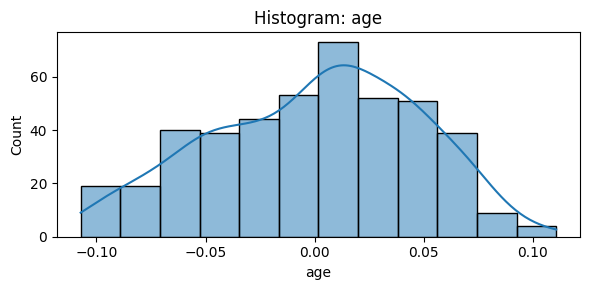

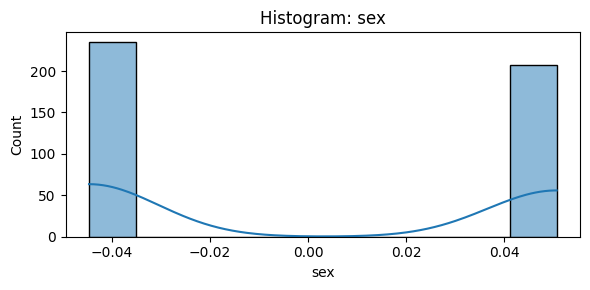

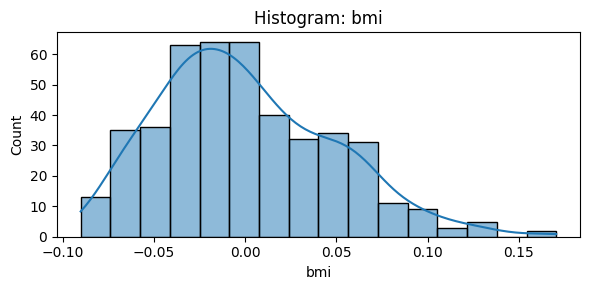

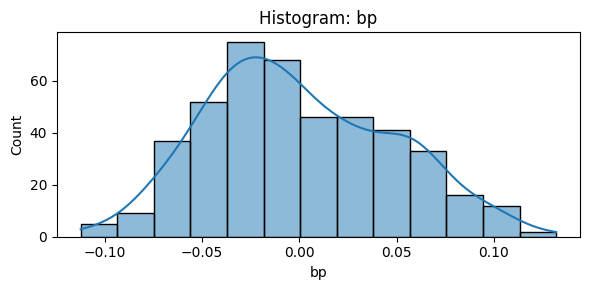

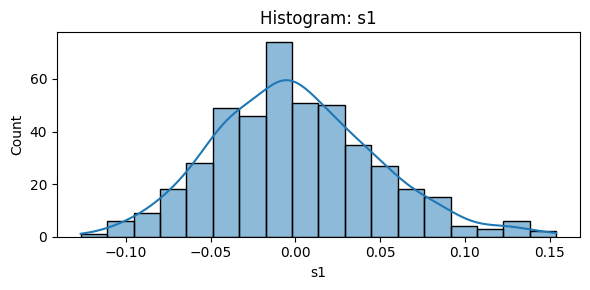

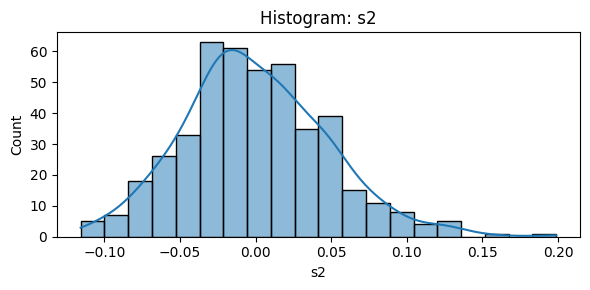

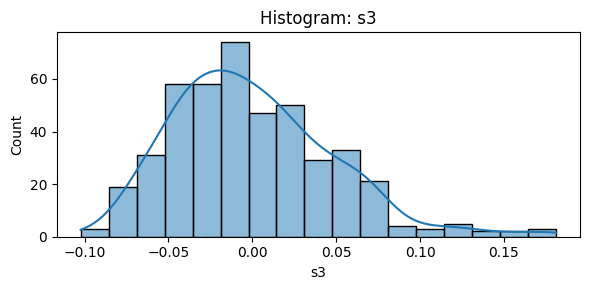

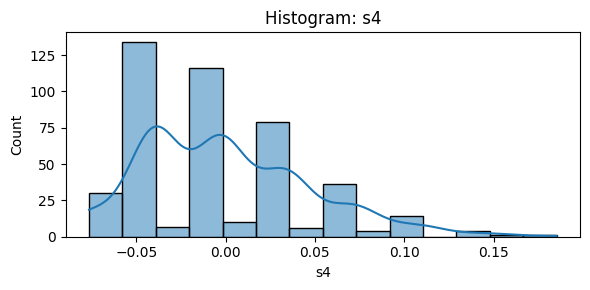

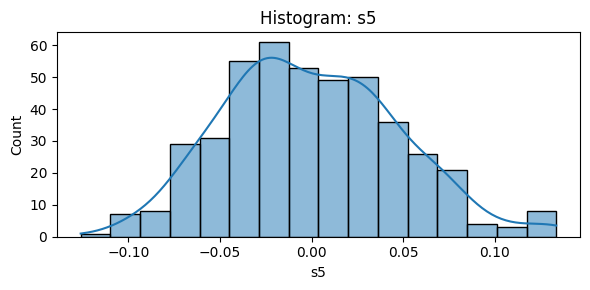

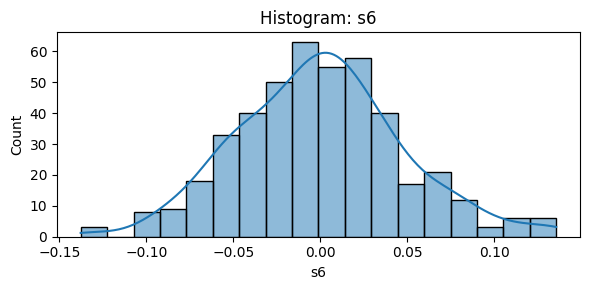

In [4]:
# Histograms (one plot per feature)
for col in feature_names:
    plt.figure(figsize=(6,3))
    sns.histplot(X_df[col], kde=True)
    plt.title(f'Histogram: {col}')
    plt.tight_layout()
    plt.show()

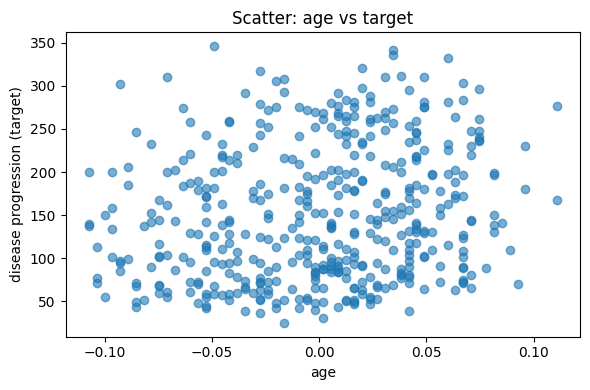

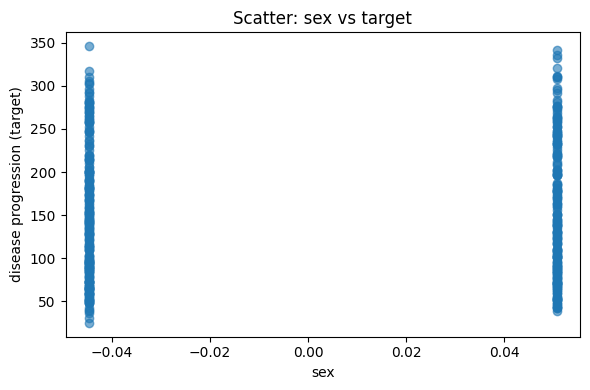

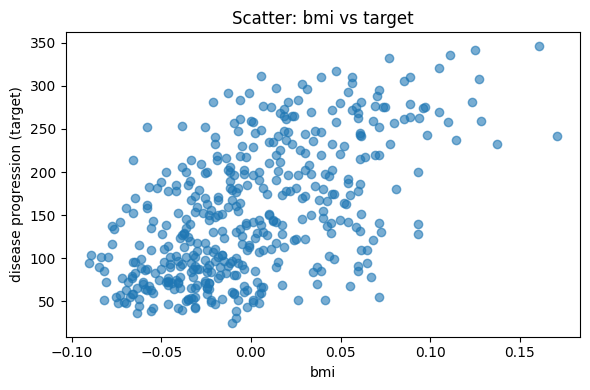

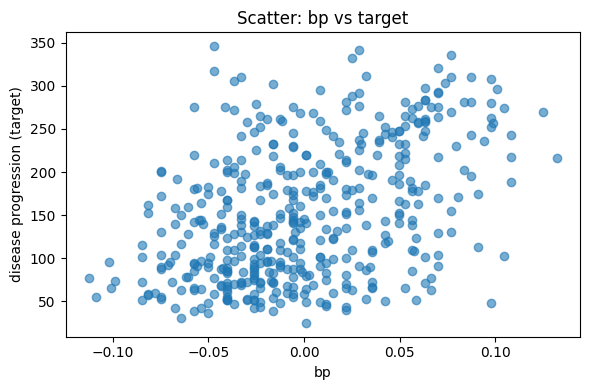

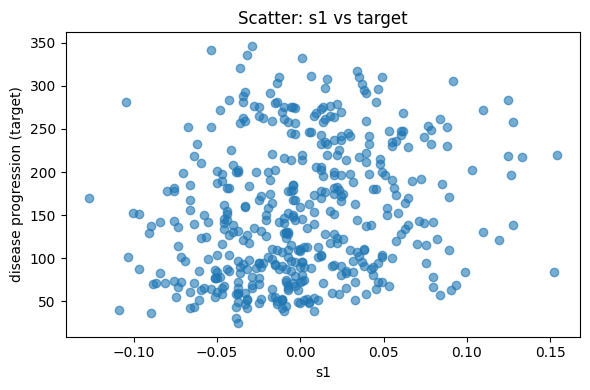

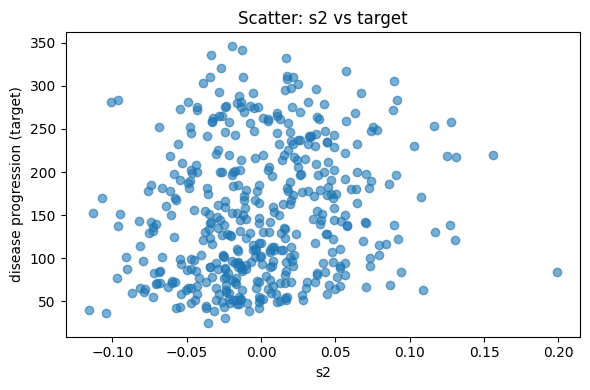

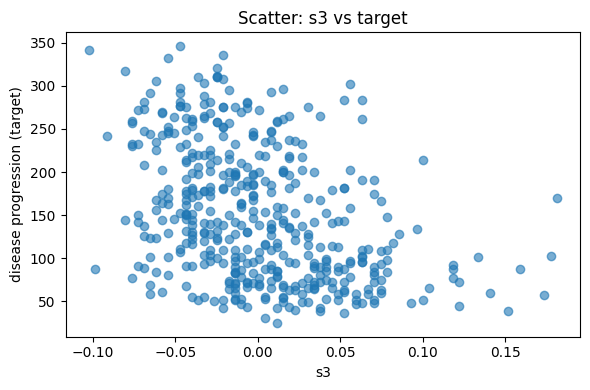

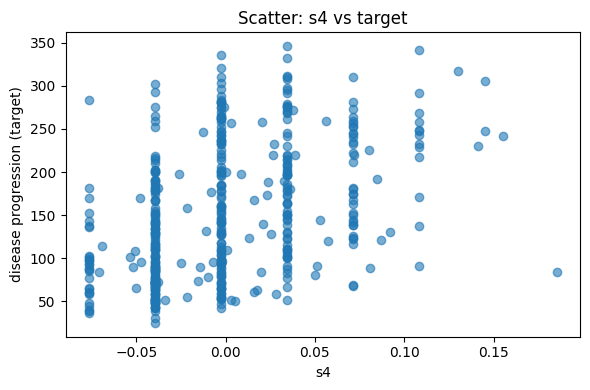

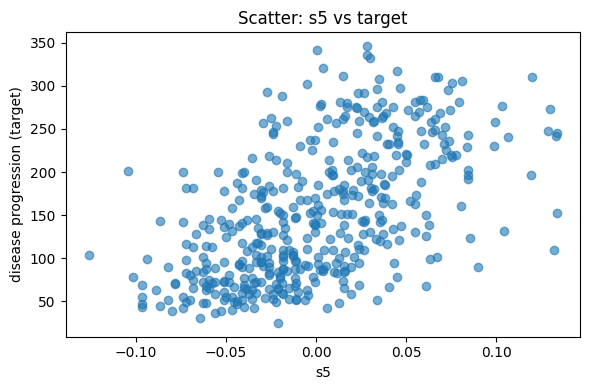

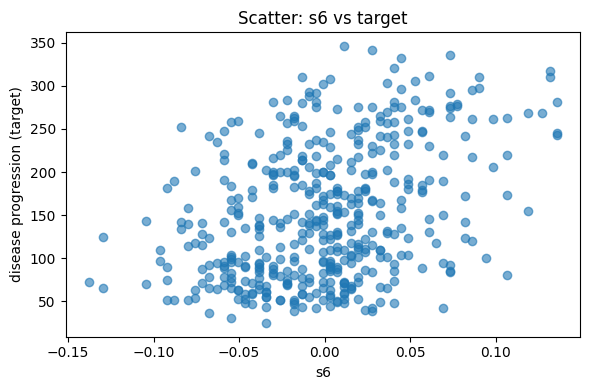

In [5]:
# Scatter plots: each feature vs target (separate figures)
for col in feature_names:
    plt.figure(figsize=(6,4))
    plt.scatter(X_df[col], y_series, alpha=0.6)
    plt.xlabel(col)
    plt.ylabel('disease progression (target)')
    plt.title(f'Scatter: {col} vs target')
    plt.tight_layout()
    plt.show()

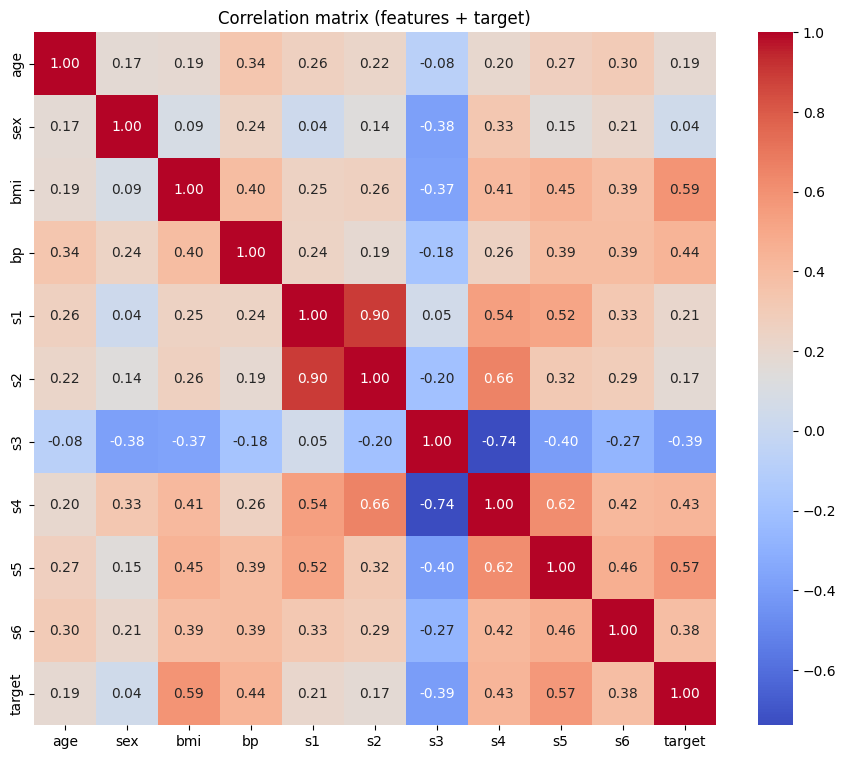

In [6]:
# Correlation matrix (full heatmap in separate figure)
corr = X_df.join(y_series).corr()
plt.figure(figsize=(11,9))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Correlation matrix (features + target)')
plt.show()

### Insights from EDA
- Report any strong correlations between features and target (use the heatmap).
- Note distributions: skewness, outliers observed in histograms and boxplots.
- For this dataset, BMI (`bmi`) often shows noticeable association with target (useful for Part 2).

Missing values per column:
age    0
sex    0
bmi    0
bp     0
s1     0
s2     0
s3     0
s4     0
s5     0
s6     0
dtype: int64


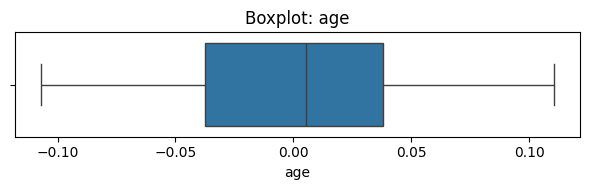

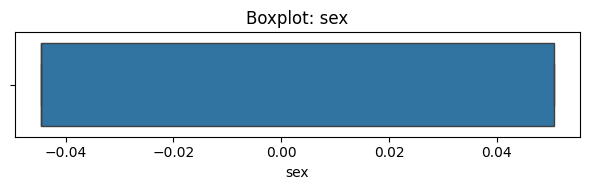

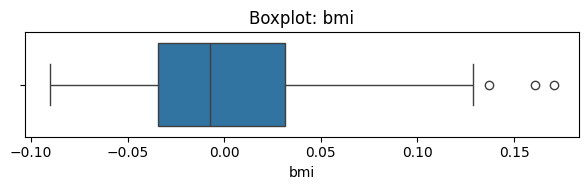

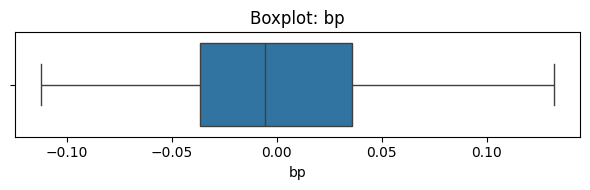

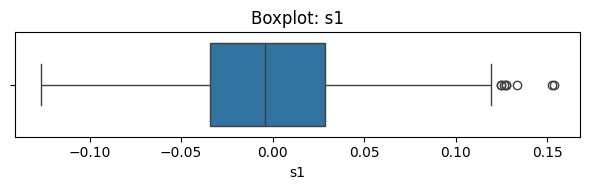

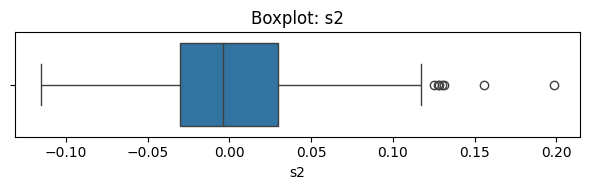

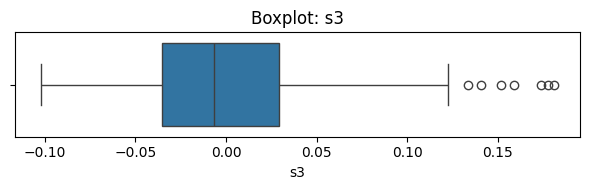

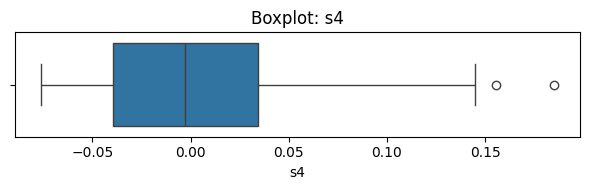

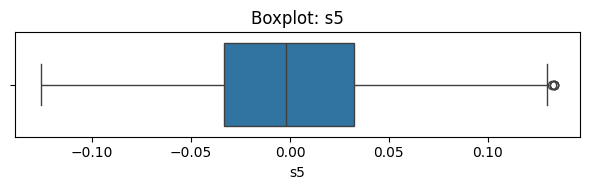

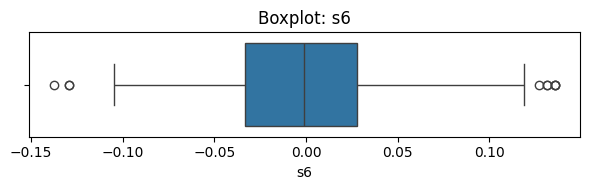

In [7]:
# Check missing values and boxplots (separate)
print('Missing values per column:')
print(X_df.isnull().sum())
for col in feature_names:
    plt.figure(figsize=(6,2))
    sns.boxplot(x=X_df[col])
    plt.title(f'Boxplot: {col}')
    plt.tight_layout()
    plt.show()

### 4) Data Cleaning
No missing values in this toy dataset. We will standardize features before models that need scaling (kNN, polynomial expansions for multivariate models). No further cleaning is required, but we will document assumptions in the Conclusion.

### 5) Train / Validation / Test split (75% / 10% / 15%)
We perform a two-step split: first separate train (75%) and temp (25%), then split temp into val/test with proportions 10% and 15% of the whole dataset.

In [8]:
# Split: 75% train, 25% temp
X = X_df.values
y = y_series.values
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.25, random_state=42)
# From temp (25% of original), allocate val: 10% and test: 15% of original -> val fraction within temp = 0.10/0.25 = 0.4
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.6, random_state=42)
print('Train size:', X_train.shape[0])
print('Validation size:', X_val.shape[0])
print('Test size:', X_test.shape[0])

Train size: 331
Validation size: 44
Test size: 67


## Part 2 — Univariate polynomial regression (BMI vs target)
Train polynomial models of degree 0..5 on the single feature `bmi`. For each model we compute Train/Validation R2, MAE, MAPE.

In [9]:
# Extract the BMI column index
bmi_idx = feature_names.index('bmi')
X_train_bmi = X_train[:, bmi_idx].reshape(-1,1)
X_val_bmi = X_val[:, bmi_idx].reshape(-1,1)
X_test_bmi = X_test[:, bmi_idx].reshape(-1,1)
results = []
models_univar = {}
for degree in range(6):
    poly = PolynomialFeatures(degree=degree, include_bias=True)
    Xtr = poly.fit_transform(X_train_bmi)
    Xv = poly.transform(X_val_bmi)
    model = LinearRegression()
    model.fit(Xtr, y_train)
    ytr_pred = model.predict(Xtr)
    yv_pred = model.predict(Xv)
    train_r2 = r2_score(y_train, ytr_pred)
    val_r2 = r2_score(y_val, yv_pred)
    train_mae = mean_absolute_error(y_train, ytr_pred)
    val_mae = mean_absolute_error(y_val, yv_pred)
    train_mape = mean_absolute_percentage_error(y_train, ytr_pred)
    val_mape = mean_absolute_percentage_error(y_val, yv_pred)
    results.append({'Degree': degree, 'Train R2': train_r2, 'Val R2': val_r2, 'Train MAE': train_mae, 'Val MAE': val_mae, 'Train MAPE': train_mape, 'Val MAPE': val_mape})
    models_univar[degree] = (poly, model)
results_df = pd.DataFrame(results)
results_df

,Degree,Train R2,Val R2,Train MAE,Val MAE,Train MAPE,Val MAPE
0,0,0.000000,-0.106957,66.201641,66.057059,0.628267,0.712639
1,1,0.349672,0.331264,52.287739,47.208472,0.483629,0.470600
2,2,0.350764,0.331631,52.207314,47.213700,0.482985,0.472397
3,3,0.350774,0.331638,52.198968,47.185414,0.482807,0.472227
4,4,0.353014,0.340758,52.092653,46.090118,0.480533,0.460503
5,5,0.354100,0.349881,52.059191,45.462121,0.480040,0.451753


### 7) Compare models — training and validation table
The table above lists metrics for degrees 0 through 5. We choose the best model by maximum validation R2 (other metrics can be used).

In [10]:
# Show the results table sorted by Val R2
results_df_sorted = results_df.sort_values('Val R2', ascending=False).reset_index(drop=True)
results_df_sorted

,Degree,Train R2,Val R2,Train MAE,Val MAE,Train MAPE,Val MAPE
0,5,0.354100,0.349881,52.059191,45.462121,0.480040,0.451753
1,4,0.353014,0.340758,52.092653,46.090118,0.480533,0.460503
2,3,0.350774,0.331638,52.198968,47.185414,0.482807,0.472227
3,2,0.350764,0.331631,52.207314,47.213700,0.482985,0.472397
4,1,0.349672,0.331264,52.287739,47.208472,0.483629,0.470600
5,0,0.000000,-0.106957,66.201641,66.057059,0.628267,0.712639


### 8) Identify the best model (by validation R2)

In [11]:
best_row = results_df.loc[results_df['Val R2'].idxmax()]
best_degree = int(best_row['Degree'])
print('Best degree (by Val R2):', best_degree)
best_row

Best degree (by Val R2): 5


Degree         5.000000
Train R2       0.354100
Val R2         0.349881
Train MAE     52.059191
Val MAE       45.462121
Train MAPE     0.480040
Val MAPE       0.451753
Name: 5, dtype: float64

### 9) Evaluate chosen model on the test set
Retrain chosen model on the training set and evaluate on the held-out test set.

In [12]:
poly_best, model_best = models_univar[best_degree]
Xtr_best = poly_best.transform(X_train_bmi)
Xtest_best = poly_best.transform(X_test_bmi)
# retrain for clarity
model_best.fit(Xtr_best, y_train)
ytest_pred = model_best.predict(Xtest_best)
test_r2, test_mae, test_mape = print_metrics(y_test, ytest_pred, prefix='Test ')

Test R2: 0.2667
Test MAE: 51.7503
Test MAPE: 0.4303


### 10) Plot train, validation, and test points with model fit (separate figures)
We plot the three sets and overlay the model fit curve computed over a dense BMI grid. Each set is plotted in its own figure for clarity.

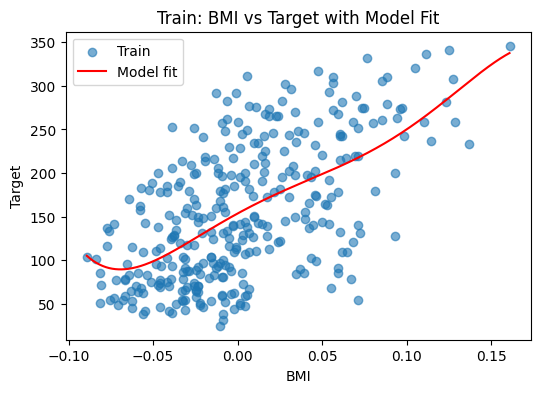

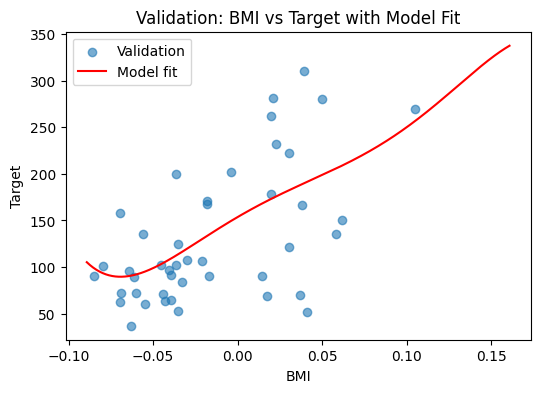

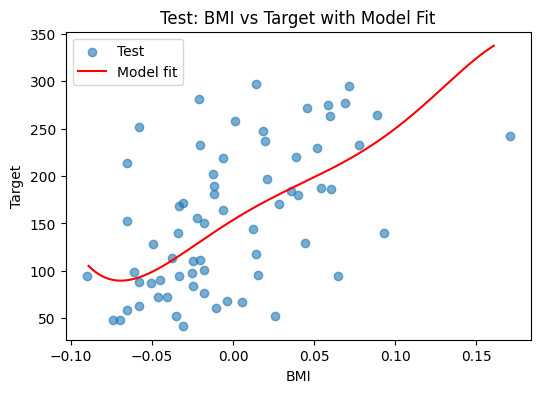

In [13]:
bmi_grid = np.linspace(X_train_bmi.min(), X_train_bmi.max(), 400).reshape(-1,1)
fit_vals = model_best.predict(poly_best.transform(bmi_grid))
# Train points figure
plt.figure(figsize=(6,4))
plt.scatter(X_train_bmi, y_train, alpha=0.6, label='Train')
plt.plot(bmi_grid, fit_vals, color='red', label='Model fit')
plt.title('Train: BMI vs Target with Model Fit')
plt.xlabel('BMI')
plt.ylabel('Target')
plt.legend()
plt.show()
# Validation points figure
plt.figure(figsize=(6,4))
plt.scatter(X_val_bmi, y_val, alpha=0.6, label='Validation')
plt.plot(bmi_grid, fit_vals, color='red', label='Model fit')
plt.title('Validation: BMI vs Target with Model Fit')
plt.xlabel('BMI')
plt.ylabel('Target')
plt.legend()
plt.show()
# Test points figure
plt.figure(figsize=(6,4))
plt.scatter(X_test_bmi, y_test, alpha=0.6, label='Test')
plt.plot(bmi_grid, fit_vals, color='red', label='Model fit')
plt.title('Test: BMI vs Target with Model Fit')
plt.xlabel('BMI')
plt.ylabel('Target')
plt.legend()
plt.show()

### 11) Model equation (two decimal precision)
We print the intercept and coefficients of the univariate polynomial model with two decimals. The polynomial features include bias, x, x^2, ... as appropriate.

In [14]:
coef = model_best.coef_
intercept = model_best.intercept_
feature_names_poly = poly_best.get_feature_names_out(['bmi'])
print('Intercept: ', f'{intercept:.2f}')
for name, c in zip(feature_names_poly, coef):
    print(f'{name}: {c:.2f}')

Intercept:  153.65
1: 0.00
bmi: 1059.89
bmi^2: -3824.15
bmi^3: -16770.23
bmi^4: 753722.52
bmi^5: -2993716.57


### 12) Predict expected progression for a chosen BMI value
We will pick a BMI value (in standardized numeric units used in this dataset) and predict using `model.predict()`.

In [15]:
chosen_bmi = float(X_df['bmi'].median())  # choose median BMI in dataset units
pred_val = model_best.predict(poly_best.transform([[chosen_bmi]]))[0]
print(f'Chosen BMI (median): {chosen_bmi:.4f}')
print(f'Predicted disease progression: {pred_val:.2f}')

Chosen BMI (median): -0.0073
Predicted disease progression: 145.74


### 13) Trainable parameters explanation
For a polynomial of degree d on a single feature, the number of trainable parameters equals the number of polynomial terms (including bias) — e.g. degree 2 -> terms [1, x, x^2] -> 3 coefficients. We show the number using `get_feature_names_out()`.

In [16]:
terms = poly_best.get_feature_names_out(['bmi'])
print('Polynomial feature terms:', terms)
print('Number of trainable parameters (including intercept):', len(terms))

Polynomial feature terms: ['1' 'bmi' 'bmi^2' 'bmi^3' 'bmi^4' 'bmi^5']
Number of trainable parameters (including intercept): 6


### 14) Conclusion for Part 2 — Univariate model
Summarize performance, where the model fails, and limitations. Include workshop talking points.
- Overfitting/underfitting: higher-degree polynomials may overfit the training data (high train R2 but low val/test R2).
- kNN workshop talking point: non-parametric models can capture complex relations but require scaling and careful choice of k.
- Logistic regression workshop talking point: regularization is key to prevent overfitting; similar ideas apply for polynomial regression by controlling degree or using regularized regressors.
- Limitations: single-feature model ignores multivariate interactions; the fit may be poor where BMI has low correlation with outcome.

## Part 3 — Multivariate models (use all features)
We run: two polynomial models (degree 2 & 3), two decision trees (`max_depth=3,6`), two kNNs (`k=3,7`), and two regularized linear regressors (Ridge & Lasso) as an interpretable substitute for 'logistic regression' which is not appropriate for regression tasks.
We evaluate Train/Val metrics and present a summary table. Plots are not required for multivariate models.

In [17]:
# Standardize features for multivariate models that need it
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s = scaler.transform(X_val)
X_test_s = scaler.transform(X_test)
multi_results = []
# Polynomial degree 2
poly2 = PolynomialFeatures(degree=2, include_bias=True)
Xtr_p2 = poly2.fit_transform(X_train_s)
Xv_p2 = poly2.transform(X_val_s)
model_p2 = LinearRegression()
model_p2.fit(Xtr_p2, y_train)
multi_results.append(('Poly d=2', model_p2, poly2, *print_metrics(y_train, model_p2.predict(Xtr_p2), prefix='Train '), *print_metrics(y_val, model_p2.predict(Xv_p2), prefix='Val ')))
# Polynomial degree 3
poly3 = PolynomialFeatures(degree=3, include_bias=True)
Xtr_p3 = poly3.fit_transform(X_train_s)
Xv_p3 = poly3.transform(X_val_s)
model_p3 = LinearRegression()
model_p3.fit(Xtr_p3, y_train)
multi_results.append(('Poly d=3', model_p3, poly3, *print_metrics(y_train, model_p3.predict(Xtr_p3), prefix='Train '), *print_metrics(y_val, model_p3.predict(Xv_p3), prefix='Val ')))
# Decision Tree max_depth=3
dt1 = DecisionTreeRegressor(max_depth=3, random_state=42)
dt1.fit(X_train, y_train)
multi_results.append(('DT d=3', dt1, None, *print_metrics(y_train, dt1.predict(X_train), prefix='Train '), *print_metrics(y_val, dt1.predict(X_val), prefix='Val ')))
# Decision Tree max_depth=6
dt2 = DecisionTreeRegressor(max_depth=6, random_state=42)
dt2.fit(X_train, y_train)
multi_results.append(('DT d=6', dt2, None, *print_metrics(y_train, dt2.predict(X_train), prefix='Train '), *print_metrics(y_val, dt2.predict(X_val), prefix='Val ')))
# kNN k=3 (needs scaling)
knn1 = KNeighborsRegressor(n_neighbors=3)
knn1.fit(X_train_s, y_train)
multi_results.append(('kNN k=3', knn1, None, *print_metrics(y_train, knn1.predict(X_train_s), prefix='Train '), *print_metrics(y_val, knn1.predict(X_val_s), prefix='Val ')))
# kNN k=7
knn2 = KNeighborsRegressor(n_neighbors=7)
knn2.fit(X_train_s, y_train)
multi_results.append(('kNN k=7', knn2, None, *print_metrics(y_train, knn2.predict(X_train_s), prefix='Train '), *print_metrics(y_val, knn2.predict(X_val_s), prefix='Val ')))
# Ridge (regularized linear regressor)
ridge = Ridge(alpha=1.0)
ridge.fit(X_train_s, y_train)
multi_results.append(('Ridge a=1.0', ridge, None, *print_metrics(y_train, ridge.predict(X_train_s), prefix='Train '), *print_metrics(y_val, ridge.predict(X_val_s), prefix='Val ')))
# Lasso
lasso = Lasso(alpha=0.1, max_iter=10000)
lasso.fit(X_train_s, y_train)
multi_results.append(('Lasso a=0.1', lasso, None, *print_metrics(y_train, lasso.predict(X_train_s), prefix='Train '), *print_metrics(y_val, lasso.predict(X_val_s), prefix='Val ')))

Train R2: 0.6048
Train MAE: 39.2158
Train MAPE: 0.3461
Val R2: 0.4263
Val MAE: 41.8020
Val MAPE: 0.4228
Train R2: 0.9098
Train MAE: 15.6508
Train MAPE: 0.1436
Val R2: -43.2799
Val MAE: 241.2153
Val MAPE: 2.3121
Train R2: 0.5095
Train MAE: 44.2599
Train MAPE: 0.3887
Val R2: 0.1983
Val MAE: 48.1262
Val MAPE: 0.4767
Train R2: 0.7680
Train MAE: 27.0902
Train MAPE: 0.2490
Val R2: 0.0417
Val MAE: 53.1232
Val MAPE: 0.5037
Train R2: 0.6243
Train MAE: 37.1188
Train MAPE: 0.3155
Val R2: 0.2807
Val MAE: 43.2045
Val MAPE: 0.4141
Train R2: 0.5241
Train MAE: 43.1787
Train MAPE: 0.3730
Val R2: 0.3895
Val MAE: 40.7500
Val MAPE: 0.3834
Train R2: 0.5187
Train MAE: 44.0936
Train MAPE: 0.3940
Val R2: 0.3908
Val MAE: 41.5542
Val MAPE: 0.4059
Train R2: 0.5186
Train MAE: 44.1077
Train MAPE: 0.3941
Val R2: 0.3928
Val MAE: 41.4794
Val MAPE: 0.4051


In [18]:
# Summarize multivariate results in a DataFrame
rows = []
for name, model, polyobj, tr_r2, tr_mae, tr_mape, val_r2, val_mae, val_mape in multi_results:
    rows.append({'Model': name, 'Train R2': tr_r2, 'Train MAE': tr_mae, 'Train MAPE': tr_mape, 'Val R2': val_r2, 'Val MAE': val_mae, 'Val MAPE': val_mape})
multi_df = pd.DataFrame(rows)
multi_df

,Model,Train R2,Train MAE,Train MAPE,Val R2,Val MAE,Val MAPE
0,Poly d=2,0.604815,39.215776,0.346057,0.426319,41.802033,0.422773
1,Poly d=3,0.909838,15.650825,0.143572,-43.279862,241.215317,2.312121
2,DT d=3,0.509503,44.259855,0.388666,0.198306,48.126248,0.476729
3,DT d=6,0.768015,27.090226,0.249038,0.041672,53.123174,0.503700
4,kNN k=3,0.624329,37.118832,0.315481,0.280741,43.204545,0.414115
5,kNN k=7,0.524134,43.178679,0.373000,0.389479,40.750000,0.383375
6,Ridge a=1.0,0.518734,44.093563,0.394017,0.390784,41.554190,0.405927
7,Lasso a=0.1,0.518560,44.107735,0.394112,0.392762,41.479364,0.405136


### Evaluate the top multivariate model on the test set
Select the model with highest validation R2 and report its test metrics.

In [19]:
best_multi = multi_df.loc[multi_df['Val R2'].idxmax()]
best_multi_name = best_multi['Model']
print('Best multivariate model by Val R2:', best_multi_name)
# find corresponding object
best_obj = None
for tup in multi_results:
    if tup[0] == best_multi_name:
        best_obj = tup
        break
name, model_obj, polyobj = best_obj[0], best_obj[1], best_obj[2]
# choose appropriate test inputs
if polyobj is not None:
    Xtest_in = polyobj.transform(X_test_s)
elif 'kNN' in name or 'Ridge' in name or 'Lasso' in name:
    Xtest_in = X_test_s
else:
    Xtest_in = X_test
ytest_pred_multi = model_obj.predict(Xtest_in)
print_metrics(y_test, ytest_pred_multi, prefix='Test ')

Best multivariate model by Val R2: Poly d=2
Test R2: 0.3994
Test MAE: 45.4931
Test MAPE: 0.3795


(0.39939206922600134, 45.49306091436858, 0.37948549864831943)

### Final conclusions and limitations
- Summarize which models performed best and why (bias–variance trade-off).
- Discuss where models fail: outliers, regions with sparse data, heteroscedasticity, and interactions not captured by simple models.
- Workshop talking points: kNN sensitivity to scaling and choice of k; regularization from logistic workshop (here using Ridge/Lasso) reduces variance at the cost of bias; choose metrics aligned with clinical goals (e.g., MAPE gives percent error).
- Next steps: cross-validation for more robust hyperparameter selection, feature engineering, and uncertainty estimation for predictions.